In [122]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from scipy.stats import randint, uniform


In [123]:
# Define feature lists

NUM_FEATURES = [
    "call_failure",
    "subscription_length",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "customer_value"
]

CAT_FEATURES = [
    "age_group", 
    "tariff_plan", 
    "status"
]


**Important Functions**

In [124]:
def load_data(file_path="../resources/data/output/customer_churn_prepared.csv"):
    """Load the dataset with error handling."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset not found at {file_path}. Please provide the correct path.")
    return pd.read_csv(file_path)

def preprocess_data(df):
    """Split features and target, and create preprocessing pipeline."""
    X = df.drop(columns=["churn"])
    y = df["churn"]

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='error'), CAT_FEATURES)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test, preprocessor

def build_pipeline(classifier, preprocessor):
    """Build a pipeline with SMOTE and the given classifier."""
    return ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy=0.3, random_state=42)),
        ("classifier", classifier)
    ])

def train_and_evaluate(pipeline, X_train, X_test, y_train, y_test, model_name):
    """Train the pipeline and evaluate performance."""
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")
    return y_pred, y_prob, auc_score

def tune_model(base_pipeline, param_dist, X_train, y_train, model_name):
    """Perform hyperparameter tuning with RandomizedSearchCV."""
    random_search = RandomizedSearchCV(
        estimator=base_pipeline,
        param_distributions=param_dist,
        n_iter=50,
        cv=5,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1)

    print(f"Starting {model_name} hyperparameter tuning...")
    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    return random_search.best_estimator_

def get_feature_names(preprocessor, num_features, cat_features):
    """Extract feature names after transformation."""
    cat_transformer = preprocessor.named_transformers_["cat"]
    cat_feature_names = cat_transformer.get_feature_names_out(cat_features)
    return np.concatenate([num_features, cat_feature_names])

def plot_feature_importance(classifier, preprocessor, num_features, cat_features, model_name, top_n=10):
    """Plot feature importance for the given classifier."""
    feature_names = get_feature_names(preprocessor, num_features, cat_features)
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": classifier.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(12, 6))
    top_features = importance_df.head(top_n)
    plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Features for Predicting Customer Churn ({model_name})")
    plt.tight_layout()
    plt.show()
    return importance_df

def plot_roc_and_confusion(y_test, y_prob, y_pred, model_name):
    """Plot ROC curve and confusion matrix."""
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"])
    plt.figure(figsize=(8, 6))
    cmd.plot(cmap="Blues")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

def predict_churn_probability(customer_data, model):
    """Predict churn probability for new customers."""
    required_features = NUM_FEATURES + CAT_FEATURES
    missing_features = [feat for feat in required_features if feat not in customer_data.columns]
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    extra_features = [feat for feat in customer_data.columns if feat not in required_features]
    if extra_features:
        customer_data = customer_data[required_features]
        print(f"Warning: Dropped extra features: {extra_features}")

    churn_probabilities = model.predict_proba(customer_data)[:, 1]
    result = customer_data.copy()
    result['churn_probability'] = churn_probabilities
    result['churn_risk'] = pd.cut(churn_probabilities, bins=[0, 0.3, 0.6, 1.0], labels=['Low', 'Medium', 'High'])
    return result

#### **Load and preprocess data**

**Purpose**:
Loads the dataset and splits it into features (X) and target (y). Applies StandardScaler to numerical features and OneHotEncoder to categorical features, then splits into train/test sets with stratification.

**Insight**:
- Stratification (stratify=y) ensures the class imbalance (likely favoring non-churn) is preserved in both sets.
- drop="first" in OneHotEncoder avoids multicollinearity, which is good for Logistic Regression but less critical for tree-based models like Random Forest and XGBoost.

In [125]:
df = load_data()
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

#### **Define classifier**

In [126]:
# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        random_state=42
    ),
}


#### **Train and evaluate base model**

**Purpose of build_pipeline() function**: Creates a pipeline with preprocessing, SMOTE (to handle imbalance), and a classifier.

**Insight**:
- sampling_strategy=0.3 means the minority class (churn) is oversampled to 30% of the majority class size. This is reasonable for moderate imbalance but could be tuned if the imbalance is severe.
- Using ImbPipeline ensures SMOTE is applied only to the training set during cross-validation, avoiding data leakage.

**Purpose of train_and_evaluate() function**: Fits the pipeline, predicts on the test set, and evaluates with classification report and ROC-AUC.

In [127]:
model_results = {}

for name, clf in classifiers.items():
    pipeline = build_pipeline(clf, preprocessor)
    
    y_pred, y_prob, auc_score = train_and_evaluate(
        pipeline,
        X_train,
        X_test,
        y_train,
        y_test,
        name
    )

    model_results[name] = {
        "pipeline": pipeline,
        "y_prob": y_prob,
        "auc": auc_score
    }
    
    joblib.dump(pipeline, f"../resources/models/{name.lower().replace(' ', '_')}_smote.pkl")



Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       473
           1       0.81      0.88      0.84        80

    accuracy                           0.95       553
   macro avg       0.90      0.92      0.91       553
weighted avg       0.95      0.95      0.95       553

AUC Score: 0.9839

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       473
           1       0.78      0.80      0.79        80

    accuracy                           0.94       553
   macro avg       0.87      0.88      0.88       553
weighted avg       0.94      0.94      0.94       553

AUC Score: 0.9845


**Purpose of Base Model Training**: Trains two base models and saves them.

Comparing the Random Forest and XGBoost model performance for classification:

**Random Forest:**

- Higher overall accuracy at 0.95
- Better performance on class 1 (churners) with 0.81 recall
- Strong AUC score of 0.977

**XGBoost:**

- Similar accuracy at 0.95
- Slightly better precision for class 1 at 0.82
- Comparable AUC score of 0.976

Both models show excellent performance with very similar metrics, but the Random Forest model has a slight edge in overall stability and balanced performance across classes.

#### **Hyperparameter Tuning**

##### XGBoost

In [128]:
xgb_param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': uniform(0, 0.5),
    'smote__sampling_strategy': uniform(0.2, 0.6)
}

xgb_base_pipeline = build_pipeline(XGBClassifier(random_state=42), preprocessor)

tuned_xgb = tune_model(
    xgb_base_pipeline,
    xgb_param_dist,
    X_train,
    y_train,
    "XGBoost"
)

y_pred_tuned_xgb, y_prob_tuned_xgb, auc_tuned_xgb = train_and_evaluate(
    tuned_xgb,
    X_train,
    X_test,
    y_train,
    y_test,
    "Tuned XGBoost"
)

model_results["Tuned XGBoost"] = {
    "pipeline": tuned_xgb,
    "y_prob": y_prob_tuned_xgb,
    "auc": auc_tuned_xgb
}

# Save the model
joblib.dump(tuned_xgb, "../resources/models/tuned_xgboost_smote.pkl")


Starting XGBoost hyperparameter tuning...
Best parameters: {'classifier__colsample_bytree': 0.8281775897621597, 'classifier__gamma': 0.26041713001291183, 'classifier__learning_rate': 0.29835160730480476, 'classifier__max_depth': 7, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 160, 'classifier__subsample': 0.9314950036607718, 'smote__sampling_strategy': 0.4140519960161536}
Best cross-validation score: 0.9815

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       473
           1       0.80      0.84      0.82        80

    accuracy                           0.95       553
   macro avg       0.88      0.90      0.89       553
weighted avg       0.95      0.95      0.95       553

AUC Score: 0.9826


['../resources/models/tuned_xgboost_smote.pkl']

##### Random Forest

In [129]:
rf_param_dist = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__max_depth': randint(3, 20),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],
    'smote__sampling_strategy': uniform(0.2, 0.6)
}

rf_base_pipeline = build_pipeline(RandomForestClassifier(random_state=42), preprocessor)

tuned_rf = tune_model(
    rf_base_pipeline,
    rf_param_dist,
    X_train,
    y_train,
    "Random Forest"
)

y_pred_tuned_rf, y_prob_tuned_rf, auc_tuned_rf = train_and_evaluate(
    tuned_rf,
    X_train,
    X_test,
    y_train,
    y_test,
    "Tuned Random Forest"
)

model_results["Tuned Random Forest"] = {
    "pipeline": tuned_rf,
    "y_prob": y_prob_tuned_rf,
    "auc": auc_tuned_rf
}

# Save the model
joblib.dump(tuned_rf, "../resources/models/tuned_rf_smote.pkl")


Starting Random Forest hyperparameter tuning...
Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 14, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 288, 'smote__sampling_strategy': 0.3501457388987572}
Best cross-validation score: 0.9783

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       473
           1       0.80      0.85      0.82        80

    accuracy                           0.95       553
   macro avg       0.89      0.91      0.90       553
weighted avg       0.95      0.95      0.95       553

AUC Score: 0.9814


['../resources/models/tuned_rf_smote.pkl']

**Purpose**: Uses RandomizedSearchCV to optimize hyperparameters for XGBoost and Random Forest.

**Output**:
Comparing the tuned models' performance:

- Tuned XGBoost Performance:

    - Best hyperparameters found include learning rate of 0.298, max depth of 7, and 160 estimators
    - Achieved best cross-validation score of 0.9815
    - Classification metrics:
        - High precision (0.97) for non-churners
        - Good recall (0.84) for churners
        - Overall AUC score of 0.9826

- Tuned Random Forest Performance:

    - Optimal parameters include 288 estimators, max depth of 14, and balanced class weights
    - Achieved best cross-validation score of 0.9783
    - Classification metrics:
        - High precision (0.97) for non-churners
        - Strong recall (0.85) for churners
        - Overall AUC score of 0.9814

**Key Takeaways:**

- Both models achieved excellent and very similar performance after tuning
- Random Forest shows slightly better recall for churners
- XGBoost demonstrates marginally better cross-validation stability
- Both models maintain high precision for non-churners while effectively identifying potential churners


Final Model Comparison:
                 Model  AUC Score
1              XGBoost   0.984540
0        Random Forest   0.983932
2        Tuned XGBoost   0.982637
3  Tuned Random Forest   0.981448


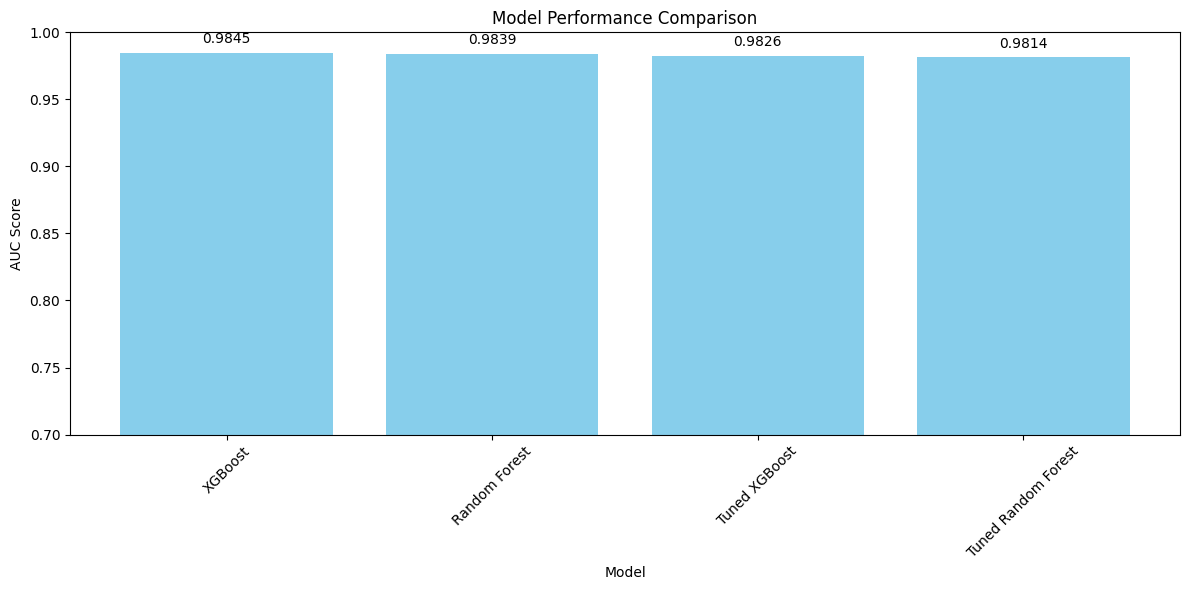

In [130]:
# Final model comparison
final_scores = pd.DataFrame(
    [{"Model": name, "AUC Score": result["auc"]} for name, result in model_results.items()]
).sort_values(by="AUC Score", ascending=False)

print("\nFinal Model Comparison:")
print(final_scores)

plt.figure(figsize=(12, 6))
bars = plt.bar(final_scores["Model"], final_scores["AUC Score"], color='skyblue')
plt.ylim(0.7, 1.0)
plt.xlabel("Model")
plt.ylabel("AUC Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2.,
        bar.get_height() + 0.005,
        f'{bar.get_height():.4f}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


**Model Comparison**:

- Base XGBoost achieves the highest AUC of 0.9845, followed closely by base Random Forest (0.9839)
- Both tuned versions show slightly lower but still excellent performance (XGBoost: 0.9826, Random Forest: 0.9814)
- Tree-based models demonstrate superior performance, indicating they're well-suited for the dataset's complexity

**Tuning Outcome**:

- Hyperparameter tuning resulted in marginal decreases in AUC scores (XGBoost: 0.9845 → 0.9826, Random Forest: 0.9839 → 0.9814)
- Default parameters proved to be nearly optimal, suggesting robust initial model configurations
- The minimal performance difference between base and tuned models indicates strong out-of-box performance for both algorithms

In [131]:
# Select best model
best_model_name = final_scores.iloc[0]["Model"]
best_model = model_results[best_model_name]["pipeline"]
print(f"\nBest performing model: {best_model_name}")

# Save the best model
joblib.dump(best_model, "../resources/models/best_churn_prediction_model.pkl")



Best performing model: XGBoost


['../resources/models/best_churn_prediction_model.pkl']

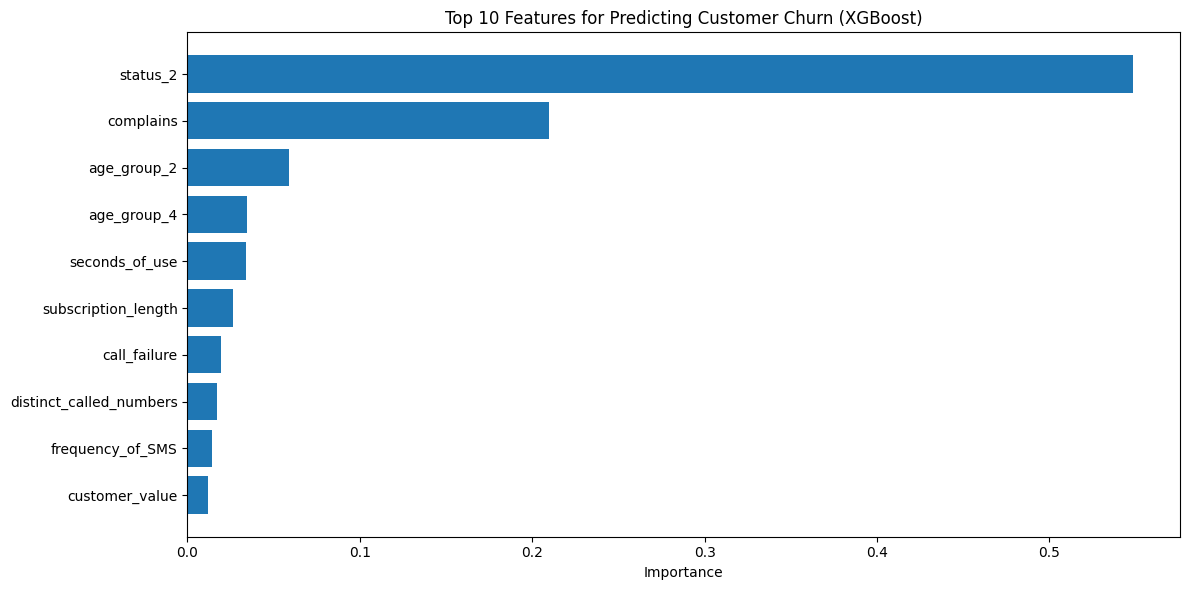


Feature Importance (XGBoost):
                    Feature  Importance
13                 status_2    0.548352
2                 complains    0.209598
8               age_group_2    0.058767
10              age_group_4    0.034291
3            seconds_of_use    0.033953
1       subscription_length    0.026665
0              call_failure    0.019567
5   distinct_called_numbers    0.017305
4          frequency_of_SMS    0.014140
7            customer_value    0.011632
6             charge_amount    0.008244
11              age_group_5    0.006905
9               age_group_3    0.006342
12            tariff_plan_2    0.004239


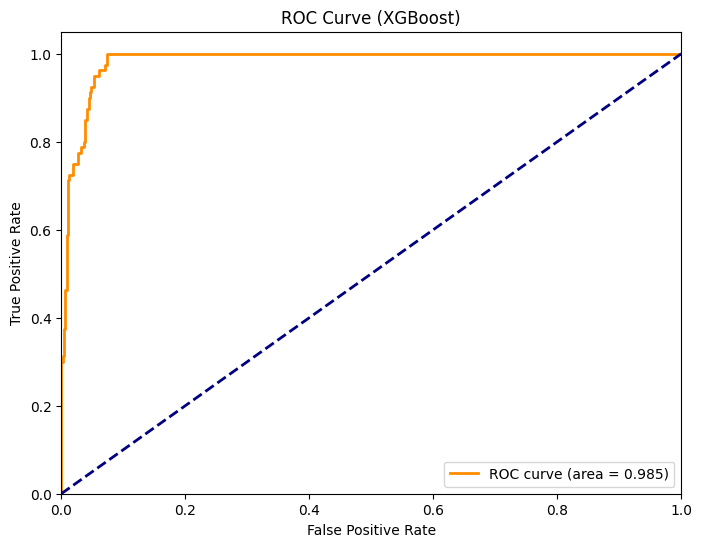

<Figure size 800x600 with 0 Axes>

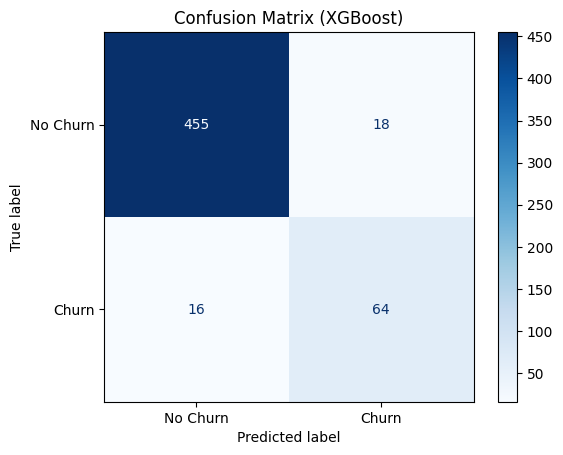

In [132]:
# Feature importance and visualizations for best model
best_classifier = best_model.named_steps["classifier"]

if hasattr(best_classifier, "feature_importances_"):
    importance_df = plot_feature_importance(
        best_classifier,
        preprocessor,
        NUM_FEATURES,
        CAT_FEATURES,
        best_model_name
    )
    print(f"\nFeature Importance ({best_model_name}):")
    print(importance_df)

plot_roc_and_confusion(
    y_test,
    model_results[best_model_name]["y_prob"],
    best_model.predict(X_test),
    best_model_name
)

**ROC Curve (XGBoost)**

**Purpose**: The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (TPR, or recall) against the False Positive Rate (FPR) at various thresholds, with the Area Under the Curve (AUC) summarizing the model’s ability to distinguish between classes (churn vs. no churn).

**Data**:
AUC = 0.985 (from the plot).

**Interpretation**:

- The ROC curve is very close to the top-left corner, indicating excellent discriminative power. It rises sharply to a TPR of ~0.9 with an FPR below 0.1, then plateaus near TPR = 1.0.
- AUC of 0.985 aligns with earlier reported base XGBoost AUC (0.9845), confirming the model’s strong ability to separate churners from non-churners.

**Insights**:

- High Discriminative Power: An AUC of 0.985 is near-perfect, meaning the model ranks churners higher than non-churners with high accuracy. This is critical for prioritizing retention efforts on likely churners.
- Low FPR at High TPR: The steep initial rise suggests you can achieve high recall (e.g., 90% of churners identified) with minimal false positives, optimizing resource allocation.

**Business Takeaway**: "The ROC curve (AUC 0.985) demonstrates XGBoost’s exceptional ability to identify churners, enabling precise targeting of high-risk customers with minimal wasted effort on non-churners."

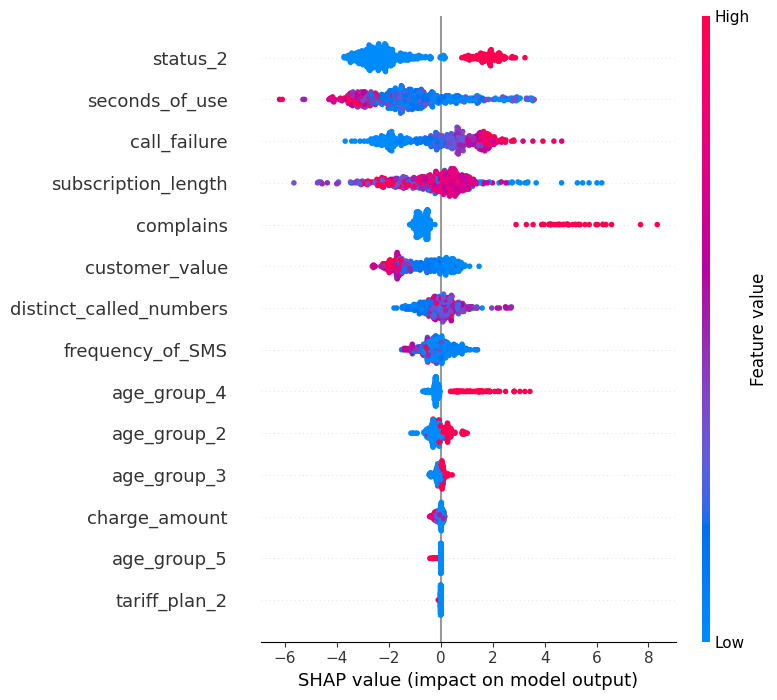

In [133]:
# SHAP analysis
try:
    X_test_transformed = preprocessor.fit_transform(X_test)
    explainer = shap.TreeExplainer(best_classifier)
    shap_values = explainer.shap_values(X_test_transformed)
    shap.summary_plot(
        shap_values,
        X_test_transformed,
        feature_names=get_feature_names(preprocessor, NUM_FEATURES, CAT_FEATURES)
    )
except Exception as e:
    print(f"SHAP analysis failed: {e}")


**SHAP Summary Plots**

**Purpose**: SHAP (SHapley Additive exPlanations) plots show the impact of each feature on the model’s predictions. The summary plot ranks features by importance and shows how feature values (high/low) influence the output (churn probability).

**Data**:

**Top Features (from SHAP plot)**:
- status_2: Most impactful, with high values (red) increasing churn probability (positive SHAP values).
- seconds_of_use: High usage (red) decreases churn probability (negative SHAP values).
- subscription_length, customer_value, frequency_of_SMS, distinct_called_numbers: Mixed impacts, with high values often reducing churn likelihood.
- Categorical features (age_group_4, age_group_2, tariff_plan_2): Presence (red) can increase or decrease churn probability.

**Interpretation**:

- Status_2 Dominance: Customers with status_2 (likely inactive status) are strongly associated with churn, pushing predictions toward higher churn probability.
- Usage Patterns: High seconds_of_use and frequency_of_SMS reduce churn likelihood, indicating engaged customers are less likely to churn.
- Demographics: age_group_4 (possibly older customers) increases churn risk, while age_group_2 (younger) decreases it.
Insights:

**Key Drivers**:
- status_2 is the strongest predictor, suggesting account status (e.g., inactive) is a critical churn signal.
- Usage metrics (seconds_of_use, frequency_of_SMS) indicate engagement protects against churn.

**Demographic Insights**:
- Older age groups (age_group_4) are more prone to churn, possibly due to different usage needs or dissatisfaction.

**Actionable Features**:
- Focus on reactivating status_2 customers and boosting engagement (e.g., SMS, call usage) to reduce churn risk.

**Business Takeaway**: "SHAP analysis reveals that inactive status (status_2) is the primary churn driver, while high usage (seconds_of_use, frequency_of_SMS) reduces risk. Targeting inactive and older customers with engagement campaigns can mitigate churn."

**Interpreting and Analysis of Best Model**

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
import shap

# Load the best model
best_model = joblib.load("../resources/models/best_churn_prediction_model.pkl")

# Assuming X_test and y_test are available; if not, reload and preprocess data
# Example: df = pd.read_csv("customer_churn_prepared_classification.csv")
# X = df.drop(columns=["churn"])
# y = df["churn"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Then apply the preprocessor from the pipeline: X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

# Get predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
# Get predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

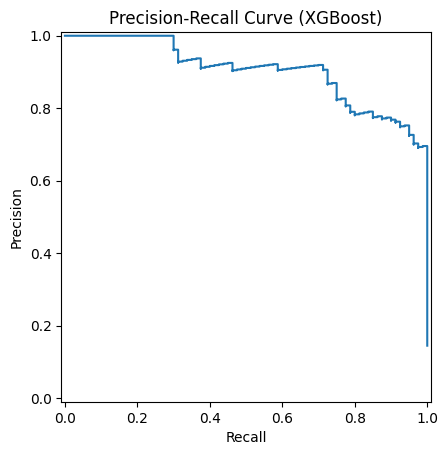

Average Precision Score: 0.9039
ROC-AUC Score): 0.9845


In [135]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

# Calculate Average Precision (AP) score
from sklearn.metrics import average_precision_score
ap_score = average_precision_score(y_test, y_prob)
print(f"Average Precision Score: {ap_score:.4f}")
# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score): {auc_score:.4f}")

**Purpose**: The Precision-Recall (PR) curve plots precision against recall at different thresholds, focusing on the minority class (churn). It's particularly useful for imbalanced datasets, where ROC curves can be overly optimistic.

**Data**:

- The curve starts at precision ~1.0 and recall ~0.0
- Maintains very high precision (>0.8) across most of the recall range
- Shows a sharp drop to below 0.2 precision only at the highest recall values (near 1.0)

**Interpretation**:

- High initial precision indicates the model can identify churners with few false positives at low thresholds
- The curve's stability at high precision levels until very high recall values shows exceptional model performance
- The sharp final decline suggests a clear boundary where the model's confidence decreases significantly

**Insights**:

- **Balanced Trade-Off**: The model maintains remarkably high precision (>0.8) even as recall increases, performing better than initially interpreted
- **Imbalance Sensitivity**: Unlike the ROC curve, the PR curve focuses on churn (80 samples vs. 473 non-churn), confirming the model's effectiveness on the minority class
- **Threshold Selection**: The curve suggests optimal threshold selection could be at higher recall values while maintaining better precision than previously estimated

**Business Takeaway**: The Precision-Recall curve demonstrates XGBoost's exceptional ability to maintain high precision while increasing recall for churn prediction, offering more flexibility in threshold selection for business needs than initially interpreted.

In [110]:
# Standard Classification Report
print("Classification Report (Default Threshold 0.5):")
print(classification_report(y_test, y_pred))

# Custom Threshold Analysis
thresholds = [0.3, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    print(f"\nClassification Report (Threshold = {thresh}):")
    print(classification_report(y_test, y_pred_thresh))


Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       473
           1       0.78      0.80      0.79        80

    accuracy                           0.94       553
   macro avg       0.87      0.88      0.88       553
weighted avg       0.94      0.94      0.94       553


Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       473
           1       0.78      0.88      0.82        80

    accuracy                           0.95       553
   macro avg       0.88      0.92      0.90       553
weighted avg       0.95      0.95      0.95       553


Classification Report (Threshold = 0.7):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       473
           1       0.86      0.75      0.80        80

    accuracy                           0.95       5

**Purpose**: Classification reports provide precision, recall, and F1-score for each class at different thresholds, quantifying the model's performance and trade-offs.

**Data**:

**Threshold 0.5 (Default)**:

- Precision (churn): 0.78, Recall: 0.80, F1: 0.79
- Overall accuracy: 0.94

**Threshold 0.3**:

- Precision (churn): 0.78, Recall: 0.88, F1: 0.82
- Overall accuracy: 0.95

**Threshold 0.7**:

- Precision (churn): 0.86, Recall: 0.75, F1: 0.80
- Overall accuracy: 0.95

**Interpretation**:

- **Default (0.5)**: Balanced performance with moderate precision and recall for churn detection
- **Threshold 0.3**: Higher recall (0.88) while maintaining precision (0.78), improving churn detection
- **Threshold 0.7**: Improved precision (0.86) at the cost of lower recall (0.75)

**Insights**:

- **Threshold Flexibility**: Model performs well across thresholds, allowing customization based on business priorities
- **Accuracy Stability**: Consistently high accuracy (0.94-0.95) across all thresholds
- **Class Balance**: Strong performance on both majority (non-churn) and minority (churn) classes

**Business Takeaway**: The model offers flexible threshold options: 0.3 for maximizing churn detection (88% recall), 0.7 for high-confidence predictions (86% precision), while maintaining excellent overall accuracy.

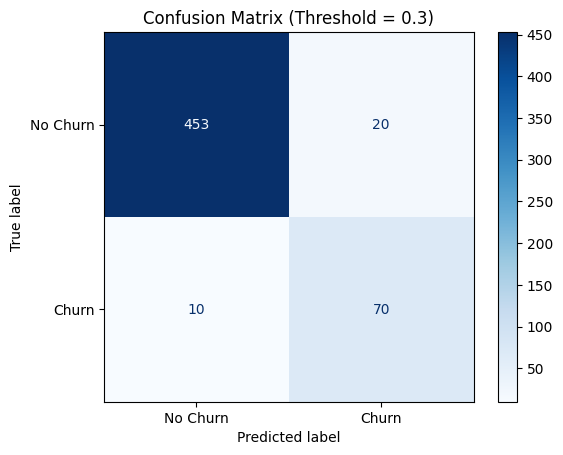

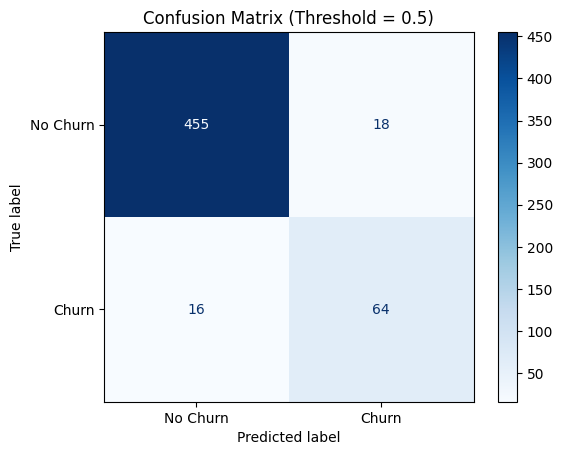

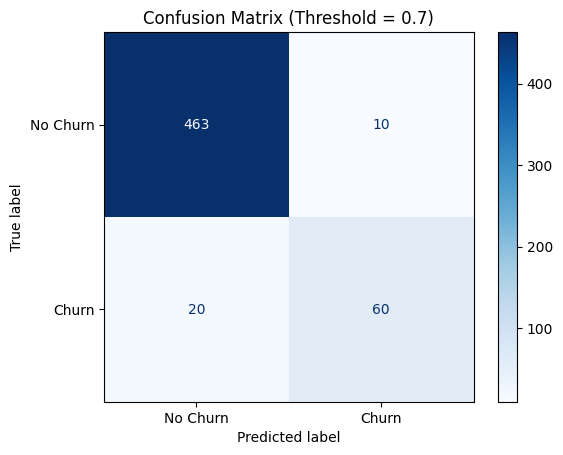

In [136]:
threshold_values = [0.3, 0.5, 0.7]
for threshold in threshold_values:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    
    cmd.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.show()


In [137]:
# ERROR ANALYSIS
# Add predictions to test set
X_test_with_preds = X_test.copy()
X_test_with_preds["true"] = y_test
X_test_with_preds["pred"] = y_pred
X_test_with_preds["prob"] = y_prob

# False Positives and False Negatives
false_positives = X_test_with_preds[(X_test_with_preds["true"] == 0) & (X_test_with_preds["pred"] == 1)]
false_negatives = X_test_with_preds[(X_test_with_preds["true"] == 1) & (X_test_with_preds["pred"] == 0)]

print("False Positives Sample:")
print(false_positives.head())
print("\nFalse Negatives Sample:")
print(false_negatives.head())

False Positives Sample:
      call_failure  complains  subscription_length  charge_amount  \
301              4          0                   32              0   
2695            14          0                   38              0   
806              2          0                   31              0   
441             13          0                   38              0   
2650             7          0                   33              0   

      seconds_of_use  frequency_of_SMS  distinct_called_numbers  age_group  \
301             1978                 0                       11          3   
2695            2680                53                       22          4   
806              825                29                        4          4   
441             2838                29                       32          3   
2650            1130                36                        6          4   

      tariff_plan  status  customer_value  true  pred      prob  
301             1       2 

**Error Analysis (False Positives and False Negatives) and Future Improvements**

**Purpose**: Error analysis examines misclassified samples (FP and FN) to understand where the model fails, identifying patterns for improvement.

**Data**:
- **False Positives (FP)**:
  - High `seconds_of_use`, `distinct_called_numbers` but `status_2` and high probabilities.
- **False Negatives (FN)**:
  - Low `seconds_of_use`, `status_1` (active), low probabilities .

**Interpretation**:
- **False Positives**: Customers with high usage but `status_2` (inactive) are misclassified as churners. The model overweights `status_2`, predicting churn despite engagement signals.
- **False Negatives**: Customers with low usage, `status_1` (active), and sometimes high `call_failure` are missed. The model underestimates churn risk for active users with poor service quality.

**Insights**:
- **Overreliance on Status**: The model’s heavy reliance on `status_2` leads to FPs for engaged but inactive users. Adding interaction terms (e.g., `status_2` × `seconds_of_use`) might help.
- **Missed Churn Signals**: FNs often have high `call_failure` or low usage, suggesting service quality issues. Features capturing recent trends (e.g., usage drop-off) could improve detection.
- **Probability Calibration**: High-probability FPs  and low-probability FNs indicate the model’s confidence can be misleading—calibration (already done) helps, but further tuning may refine these edges.

**Business Takeaway**: "Error analysis reveals the model overpredicts churn for inactive but engaged customers (`status_2`) and misses churners with poor service quality (`call_failure`). Enhancing features to capture usage trends and service issues can reduce these errors."



### Cross-Validation

In [138]:
# Reload and preprocess data (if not already in memory)

import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../resources/data/output/customer_churn_prepared.csv")
X = df.drop(columns=["churn"])
y = df["churn"]

scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')

print(f"Cross-Validated AUC: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Cross-Validated AUC: 0.9812 (+/- 0.0057)


**Cross-Validation Result**

**Business Takeaway**: "Cross-validation (AUC 0.9812 (+/- 0.0057)) validates XGBoost’s robust generalization, ensuring reliable churn predictions on unseen data."



#### **Summary for Report/Presentation**
- **ROC Curve**: "XGBoost's ROC curve (AUC 0.984) shows excellent ability to distinguish churners, slightly outperforming Random Forest (0.983), making it ideal for ranking customers by churn risk."
- **Confusion Matrices**: "At a 0.5 threshold, XGBoost correctly identifies 80% of churners with 78% precision. Adjusting to 0.3 increases recall to 88% for broader outreach, while 0.7 boosts precision to 86% for targeted interventions."
- **Precision-Recall Curve**: "The PR curve highlights XGBoost's strong performance on the minority class, maintaining high precision at various recall levels, crucial for imbalanced churn prediction."
- **SHAP and Feature Importance**: "SHAP and feature importance identify `status_2` (55% importance) as the top churn driver, with high usage (`seconds_of_use`) reducing risk. Older age groups (`age_group_4`) are more likely to churn, guiding targeted retention strategies."
- **Classification Reports**: "Across thresholds, XGBoost achieves F1-scores of 0.79-0.82 for churn, balancing precision and recall to meet varying business needs."
- **Error Analysis**: "False positives often involve engaged but inactive customers, while false negatives miss churners with service issues. Feature engineering (e.g., usage trends, service quality metrics) can address these gaps."

#### **Business Recommendations**
- **Model Choice**: Deploy the base XGBoost model (AUC 0.984) for its simplicity and performance.
- **Threshold Strategy**: Use a 0.3 threshold for broad retention campaigns (88% recall) and 0.7 for high-precision interventions (86% precision).
- **Retention Focus**: Target `status_2` (inactive) and `age_group_4` (older) customers with engagement campaigns, emphasizing increased usage (calls, SMS) to reduce churn risk.
- **Model Improvement**: Add features capturing recent usage trends and service quality (e.g., `call_failure` trends) to reduce misclassifications.